Análise do dia 26/03 através do modelo LDA.

In [1]:
# Importar bibliotecas

# gerais
import sys
import os
from pathlib import Path
import re
import numpy as np
import pandas as pd
from pprint import pprint
from tqdm import tqdm
from ast import literal_eval

# Gensim
import gensim, spacy, logging, warnings
import gensim.corpora as corpora
from gensim.utils import lemmatize, simple_preprocess
from gensim.models import CoherenceModel
from gensim.models.ldamulticore import LdaMulticore

# NLTK Stop words
import nltk
from nltk.corpus import stopwords

#plot
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
%matplotlib inline
from wordcloud import WordCloud, STOPWORDS

In [2]:
# Criando stopwords em português utilizando a biblioteca nltk

nlp = spacy.load("pt_core_news_sm")
pt_stopwords = sorted([token.text for token in nlp.vocab if token.is_stop])
list_exclude = ['obrigado', 'bom', 'mal', 'nenhuma', 'maior', 
             'bem', 'não', 'máximo', 'boa', 'mais',
               'bastante', 'certamente', 'certeza', 'contra',
                'quarentena', 'coronavírus', 'presidente', 'impeachment', 'demitido', 'demitida']
for word in list_exclude:
    nlp.vocab[word].is_stop = False
list_include = set(['o', 'a', 'tá', 'ta', 'ser', 'pro', 'to', 'tô', 'vc', 'você', 'voce', 'pra',
                    'pq', 'é', 'vou', 'que','tão', 'gt', 'de', 'da', 'do', 'em', 'uma', 'lá',
                    'já', 'no', 'para', 'na', 'com', 'um', 'minha', 'se', 'isso', 'por', 'vou',
                    'os', 'isso', 'como', 'mesmo', 'tenho', 'aqui', 'ele', 'ela', 'quem', 'fazer',
                    'eu', 'só', 'ai', 'mais', 'só', 'querer', 'https', 'ter', 'estar', 'ficar',
                    'dos', 'das', 'vcs', 'jairbolsonaro', 'tava', 'nao', 'sao', 'ja', 'so', 'nossa',
                    'nosso', 'estao', 'tco', 'me', 'dia', 'te', 'ver', 'sera', 'porra', 'fez', 'ne',
                    'kkkkkk', 'puta', 'kkkkkkkk', 'hj', 'afff', 'gbr', 'meu', 'cara', 'guri', 'cmg',
                    'ctg', 'agr', 'pqp', 'vdd', 'eh', 'va', 'fudeu', 'fuder', 'fodeu', 'foda', 'obg',
                   'nem', 'numa', 'num', 'nuns', 'ces', 'voces', 'oce', 'oces', 'kkkk', 'vao', 'via',
                    'hj', 'hoje', 'tudo', 'todo', 'toda', 'ir', 'vir', 'bem', 'sair', 'tao']
                  )
for w in list_include:
    nlp.vocab[w].is_stop = True
stop_words = sorted([token.text for token in nlp.vocab if token.is_stop])

# Preparação dos dados

In [3]:
# import dos dados

df = pd.read_csv('0326_preprocessado.csv')

In [4]:
# import dos tokens

df_tokens = pd.read_csv('tokens_unicos_10k.csv')

In [5]:
# criação de lista de tokens

lista_token = []

for row in range(0, len(df_tokens)):
    lista_token.append(df_tokens.iloc[row,1])
    
lista_token = set(lista_token)

In [6]:
# filtranso os tokens para aparecer apenas os 10 mil mais frequentes

df['token2'] = df.token.apply(lambda x: str(list(set(literal_eval(x)).intersection(lista_token))))

In [7]:
# função para reverter os tokens processados em lista de tuples

def strip_characters(text):
    t = re.sub(r'\(|\)|:|,|;|\.|’|”|“|\?|%|>|<|\[|\]', '', text)
    t = re.sub(r'/', ' ', t)
    t = t.replace("'",'')
    return t

In [8]:
# aplica função em todos os tokens

df['token2'] = df['token2'].apply(lambda x: strip_characters(x))
df['token2'] = df['token2'].apply(lambda x: str(x).split(' '))

In [9]:
# transforma os tokens em lista

lista = list(df['token2'])

In [10]:
# Build the bigram and trigram models

bigram = gensim.models.Phrases(lista, min_count=5, threshold=100)
bigram_mod = gensim.models.phrases.Phraser(bigram)

trigram = gensim.models.Phrases(bigram[lista], threshold=100)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [11]:
# função para preprocessar palavras

def process_words(texts, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts1 = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts2 = [bigram_mod[doc] for doc in texts1]
    texts3 = [trigram_mod[bigram_mod[doc]] for doc in texts2]
    texts4 = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts3]    
    return texts4

In [12]:
# Processing the abstract

texto = process_words(lista)

# Modelagem

In [13]:
# Criar dicionário

id2word = corpora.Dictionary(texto)

In [14]:
# Criar o Corpus: A Frequência das palavras nos documentos

corpus = [id2word.doc2bow(text) for text in texto]

In [15]:
# Função para determinar a melhor quantidade de tópicos para a modelagem

def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=5):
    coherence_values = []
    model_list = []
    for num_topics in tqdm(range(start, limit, step)):
        model = LdaMulticore(corpus, id2word=id2word, num_topics=10)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [16]:
# Colocando parametros na função

model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=texto, start=2, limit=30, step=2)

100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [21:33<00:00, 92.42s/it]


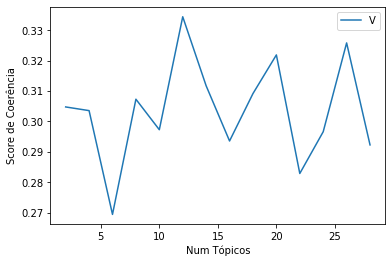

In [17]:
# Mostrando visualmente a quantidade de tópicos

limit=30; start=2; step=2;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Tópicos")
plt.ylabel("Score de Coerência")
plt.legend(("Valores de Coerência"), loc='best')
plt.show()

In [18]:
# Lista dos valores de coerência, para melhor identificar o ponto de inflexão do gráfico

for m, cv in zip(x, coherence_values):
    print("A quantidade de tópicos =", m, " tem um valor de coerência de ", round(cv, 4))

A quantidade de tópicos = 2  tem um valor de coerência de  0.3048
A quantidade de tópicos = 4  tem um valor de coerência de  0.3036
A quantidade de tópicos = 6  tem um valor de coerência de  0.2694
A quantidade de tópicos = 8  tem um valor de coerência de  0.3073
A quantidade de tópicos = 10  tem um valor de coerência de  0.2973
A quantidade de tópicos = 12  tem um valor de coerência de  0.3344
A quantidade de tópicos = 14  tem um valor de coerência de  0.3117
A quantidade de tópicos = 16  tem um valor de coerência de  0.2936
A quantidade de tópicos = 18  tem um valor de coerência de  0.3092
A quantidade de tópicos = 20  tem um valor de coerência de  0.3219
A quantidade de tópicos = 22  tem um valor de coerência de  0.2829
A quantidade de tópicos = 24  tem um valor de coerência de  0.2966
A quantidade de tópicos = 26  tem um valor de coerência de  0.3258
A quantidade de tópicos = 28  tem um valor de coerência de  0.2923


Aqui conseguimos determinar a melhor quantidade de tópicos a serem analisados, que é 8 tópicos

In [19]:
# Vamos agora construir de fato o modelo LDA

lda_model = LdaMulticore(corpus=corpus,
                        id2word=id2word,
                        num_topics=4, 
                        random_state=42,
                        chunksize=100,
                        passes=10,
                        per_word_topics=True)

In [20]:
# Computar a perplexidade do modelo (quanto menor, melhor)

print('\nPerplexidade: ', lda_model.log_perplexity(corpus))


Perplexidade:  -7.104080474729473


In [21]:
# Computar o Score de Coerência

coherence_model_lda = CoherenceModel(model=lda_model, texts=lista, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nScore de Coerência: ', coherence_lda)


Score de Coerência:  0.266717868426731


In [22]:
# Visualização dos tópicos em clusters

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.025674  0.351844       1        1  35.410301
1     -0.219657 -0.037899       2        1  22.364035
3     -0.151235 -0.183343       3        1  21.202620
0      0.345218 -0.130602       4        1  21.023041, topic_info=            Term          Freq         Total Category  logprob  loglift
12        corona  26108.000000  26108.000000  Default  30.0000  30.0000
0      bolsonaro  29127.000000  29127.000000  Default  29.0000  29.0000
47    presidente  25574.000000  25574.000000  Default  28.0000  28.0000
146        virus  12352.000000  12352.000000  Default  27.0000  27.0000
205       quando  10818.000000  10818.000000  Default  26.0000  26.0000
..           ...           ...           ...      ...      ...      ...
15   coronavirus   4708.585449  24489.480469   Topic4  -3.8693  -0.0893
83          casa   3044.745361  12880.129883   Topic4  -4.3053   0.1173
40         gente   2560.748535   9224.881836   Topic4  -4.4784   0.2779
149        agora   1728.222046   8513.729492   Topic4  -4.8716  -0.0350
201        mundo   1457.587280   6751.277832   Topic4  -5.0419   0.0266

[197 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
142       3  0.999935   acabar
149       1  0.436119    agora
149       2  0.204846    agora
149       3  0.156101    agora
149       4  0.202966    agora
...     ...       ...      ...
146       4  0.999904    virus
90        4  0.999430    volta
460       2  0.690454   voltar
460       3  0.309475   voltar
512       2  0.999680  vontade

[207 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 2, 4, 1])

In [23]:
# Escolhe o modelo

optimal_model = model_list[3]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.145*"presidente" + 0.060*"bolsonaro" + 0.028*"povo" + 0.017*"governo" + '
  '0.017*"brasil" + 0.014*"contra" + 0.013*"governador" + 0.012*"doria" + '
  '0.011*"nada" + 0.010*"agora"'),
 (1,
  '0.068*"depois" + 0.049*"pandemia" + 0.025*"coisa" + 0.016*"final" + '
  '0.015*"casa" + 0.013*"meio" + 0.012*"social" + 0.011*"unica" + '
  '0.010*"ninguem" + 0.010*"isolamento"'),
 (2,
  '0.044*"bolsonaro" + 0.030*"presidente" + 0.023*"muito" + 0.021*"tempo" + '
  '0.018*"mundo" + 0.016*"corrente" + 0.014*"bom" + 0.013*"pandemia" + '
  '0.012*"menos" + 0.010*"qual"'),
 (3,
  '0.024*"primeiro" + 0.018*"pai" + 0.015*"medo" + 0.015*"tu" + 0.014*"casa" + '
  '0.014*"quando" + 0.014*"kkkkkkk" + 0.013*"grupo" + 0.012*"gente" + '
  '0.011*"acabar"'),
 (4,
  '0.157*"coronavirus" + 0.035*"brasil" + 0.031*"pandemia" + 0.023*"saude" + '
  '0.022*"novo" + 0.016*"quando" + 0.015*"acabar" + 0.012*"agora" + '
  '0.012*"crise" + 0.011*"mundo"'),
 (5,
  '0.035*"acabar" + 0.034*"cabelo" + 0.028*"quando"

In [24]:
# Encontrar qual o principal tópico em cada tweet

def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=lista):
    # Output
    sent_topics_df = pd.DataFrame()

    # Seleciona o principal tópico de cada tweet
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Calcula o principal tópico, o percentual de contribuição e as palavras chaves de cada tweet
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => mostra o principal tópico
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Principal_Topico', 'Perc_Contributicao', 'Palavras_Chave']

    # Inclui o texto original no final do DataFrame
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

In [25]:
# roda a função de calcular os principais tópicos de cada tweet

df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=lista)

In [26]:
# Formata o DataFrame

df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Index_DF_Original', 'Principal_Topico', 'Perc_Contrib_Topico', 'Palavras_Chave', 'Tweets']

In [27]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Principal_Topico')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contributicao'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topico', "Topico_Perc_Contrib", "Palavras_Chave", "Tweet"]

# Show
sent_topics_sorteddf_mallet

,Topico,Topico_Perc_Contrib,Palavras_Chave,Tweet
0,0.0,0.9470,"presidente, bolsonaro, povo, governo, brasil, ...","[assim, certo, recado, der, estupidez, dar, bo..."
1,1.0,0.9250,"depois, pandemia, coisa, final, casa, meio, so...","[tco, incorporar, rever, periodo, momento, ati..."
2,2.0,0.9308,"bolsonaro, presidente, muito, tempo, mundo, co...","[ainda, politicagem, das, numa, dar, bolsonaro..."
3,3.0,0.9250,"primeiro, pai, medo, tu, casa, quando, kkkkkkk...","[deixar, dia, ja, quando, noite, nao, acabar, ..."
4,4.0,0.9437,"coronavirus, brasil, pandemia, saude, novo, qu...","[bem, ainda, zero, obviamente, certeza, campan..."
5,5.0,0.9182,"acabar, cabelo, quando, fim, vontade, cabeca, ...","[nunca, comida, mandar, cortar, dos, cabelo, t..."
6,6.0,0.9182,"passar, casa, deus, quando, mim, alguem, acaba...","[comigo, estudar, nunca, comecou, dar, tanto, ..."
7,7.0,0.9250,"corona, virus, gente, morrer, pegar, ainda, ma...","[inferno, dentro, dos, vsf, corona, nada, muit..."
8,8.0,0.9182,"logo, sim, coronavirus, cu, casa, quase, tomar...","[sim, ja, talvez, simmm, ne, nao, rinite, quas..."
9,9.0,0.9400,"bolsonaro, nunca, vida, vez, gente, normal, fa...","[limpar, essencial, bolsonaro, casa, coisa, ch..."


In [28]:
# Numero de tweets por topico

topic_counts = df_topic_sents_keywords['Principal_Topico'].value_counts()

# Porcentagem de tweets por tópico
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Número do tópico e suas palavras chave
topic_num_keywords = df_topic_sents_keywords[['Principal_Topico', 'Palavras_Chave']]

# Concatena as colunas
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Renomeia as colunas
df_dominant_topics.columns = ['Principal_Topico', 'Palavras_Chave', 'Qtd_Tweets', 'Perc_Tweets']

# Mostra o DataFrame
df_dominant_topics

,Principal_Topico,Palavras_Chave,Qtd_Tweets,Perc_Tweets
0.0,2.0,"bolsonaro, presidente, muito, tempo, mundo, co...",47409.0,0.1916
1.0,3.0,"primeiro, pai, medo, tu, casa, quando, kkkkkkk...",22003.0,0.0889
2.0,1.0,"depois, pandemia, coisa, final, casa, meio, so...",20148.0,0.0814
3.0,0.0,"presidente, bolsonaro, povo, governo, brasil, ...",16985.0,0.0686
4.0,9.0,"bolsonaro, nunca, vida, vez, gente, normal, fa...",27640.0,0.1117
...,...,...,...,...
247485.0,1.0,"depois, pandemia, coisa, final, casa, meio, so...",NaN,NaN
247486.0,4.0,"coronavirus, brasil, pandemia, saude, novo, qu...",NaN,NaN
247487.0,2.0,"bolsonaro, presidente, muito, tempo, mundo, co...",NaN,NaN
247488.0,4.0,"coronavirus, brasil, pandemia, saude, novo, qu...",NaN,NaN


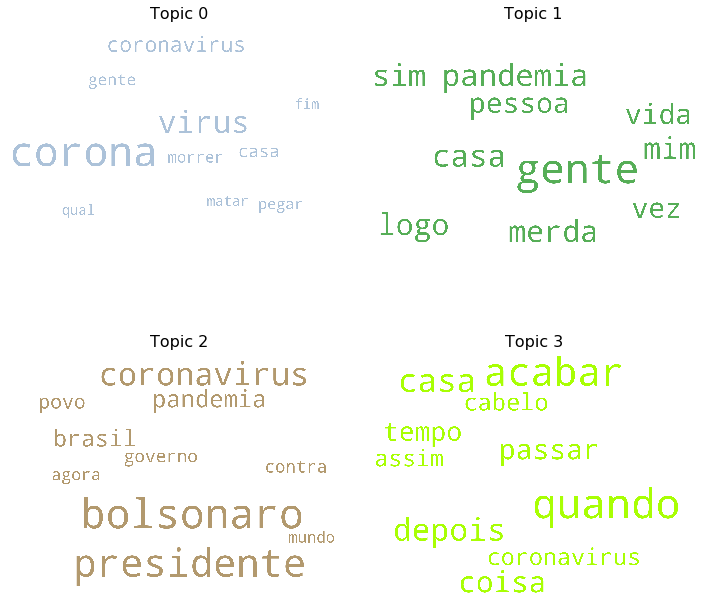

In [29]:
# Cria wordclouds

cols = [color for name, color in mcolors.XKCD_COLORS.items()]

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()